When collecting field observations we are often confronted with large agricultural fields or even entire watersheds that require knowledge of sampling strategies to ensure that we cover and represent the variable under study.

In this exercise, we will use a real watershed boundary from the [Konza Prairie](https://kpbs.konza.k-state.edu/), which is located in the northern part of the Flint Hills region in Kansas. The Konza Prairie Biological Station is world-class experiment station and is one the largest protected tallgrass prairie ecosystems in the world.

This exercise is aimed at generating random grid cells to collect field observations.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, box


In [3]:
# Load Konza Prairie watershed
df = pd.read_csv("../datasets/konza_prairie_K1B_watershed.csv")
df.head(3)


,lon,lat
0,-96.560971,39.083618
1,-96.561303,39.084147
2,-96.561698,39.084579


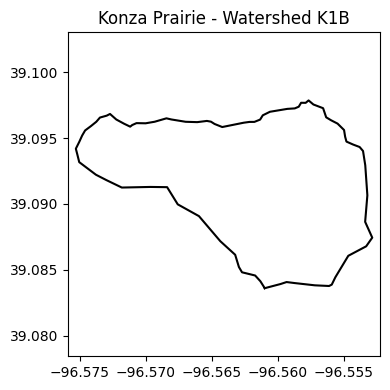

In [13]:
# Visualize watershed
plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(df["lon"],df["lat"], '-k')
plt.axis('equal')
plt.tight_layout()
plt.show()


## Test if point is inside watershed 

In [14]:
# Create a point using Shapely
p = Point(-96.560, 39.092) # Intensionally inside the watershed

# Create a polygon of the watershed using Shapely
# We will make use of the itertuples method to conver a Pandas row into a tuple
coords = list(df.itertuples(index=False, name=None))
watershed = Polygon(coords)

# Check if the point is inside polygon
p.within(watershed)


True

In [15]:
# Access point coordinates
print(f'x:{p.x} and y:{p.y}')

x:-96.56 and y:39.092


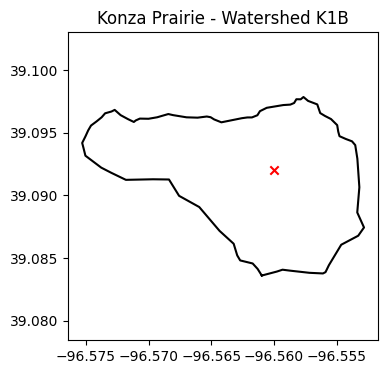

In [16]:
# Confirm visually
lon_watershed,lat_watershed = watershed.boundary.xy

plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')
plt.scatter(p.x,p.y, marker='x', color='r')
plt.axis('equal')
plt.show()


## Generate random sampling points

Let's generate a set of *N* random sampling points within the watershed.


In [17]:
# Let's make use of the watershed bounds for our points
# bounding box is a (minx, miny, maxx, maxy) 
watershed.bounds


(-96.57528919, 39.08361847, -96.55282197, 39.09784962)

In our next step we will try to learn how to generate the random coordinates and convert these coordinates into a Shapely MultiPoint object. We will re-write part of this code in a later section once we know how to do this. We also need to see whether creating the points this way would work. We will need to confirm this visually.


In [62]:
# For reproducibility
np.random.seed(1)

# Generate N random points
N = 30
rand_lon = np.random.uniform(low=watershed.bounds[0], high=watershed.bounds[2], size=N)
rand_lat = np.random.uniform(low=watershed.bounds[1], high=watershed.bounds[3], size=N)


In [63]:
# Create tuples with Lat and Lon for each point
rand_points = []
for n in range(len(rand_lon)):
    rand_points.append(Point(rand_lon[n],rand_lat[n]))


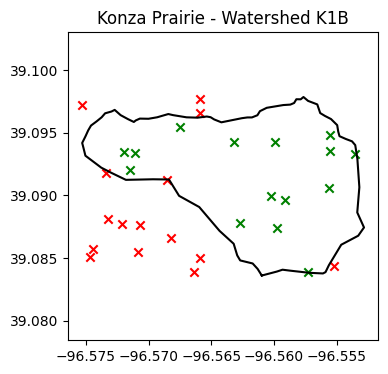

In [64]:
# Visualize random points

plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')

# Iterate over each point in MultiPoint object P
for p in rand_points: 
    
    # If point is within watershed, then make it green, oterhwise red.
    if p.within(watershed):
        plt.scatter(p.x, p.y, marker='x', color='g')
    else:
        plt.scatter(p.x, p.y, marker='x', color='r')

plt.axis('equal')
plt.show()


In [66]:
# Use what we learned to create a list of points, all within the boundary

# For reproducibility
np.random.seed(1)

# Empty list to hold random points
rand_points = []
while len(rand_points) < N:
    
    # Generate random latitude and longitude
    rand_lon = np.random.uniform(low=watershed.bounds[0], high=watershed.bounds[2])
    rand_lat = np.random.uniform(low=watershed.bounds[1], high=watershed.bounds[3])
    
    # Convert the random lat and lon into a Shapely Point object
    point = Point(rand_lon, rand_lat)
    
    # Check if within watershed
    if point.within(watershed):
        rand_points.append(Point(rand_lon,rand_lat))


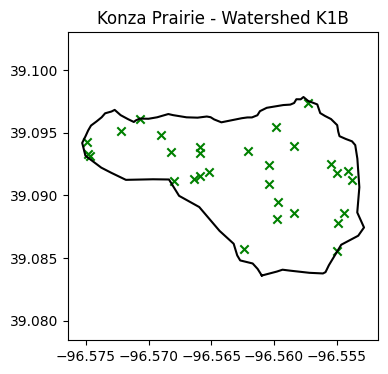

In [73]:
# Visualize random points

plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')

for p in rand_points: 
    if p.within(watershed):
        plt.scatter(p.x, p.y, marker='x', color='g')
    else:
        plt.scatter(p.x, p.y, marker='x', color='r')
plt.axis('equal')
plt.show()


## Random sampling grid cells

Another option to random sampling points is to discretize the area of the water shed into *N* grid cells and then randomly select some of these cells to conduct the field sampling.

To solve this problem we will need to generate square grid cells and determined whether they are fully within the boundary of the watershed. This approach will make sure that no grid cell overlaps with the watershed boundary.


In [74]:
# Create a test grid cell using the box method
# box(minx, miny, maxx, maxy, ccw=True)
b = box(-96.565, 39.090, -96.560, 39.095)
b.exterior.xy


(array('d', [-96.56, -96.56, -96.565, -96.565, -96.56]),
 array('d', [39.09, 39.095, 39.095, 39.09, 39.09]))

In [75]:
# Extract coordinates from the box object
b_lon, b_lat = list(b.exterior.coords.xy)


In [76]:
# Test whehter box is COMPLETELY inside the watershed
# For other options such as: intersect, overlaps, and touches see the docs
b.within(watershed)


True

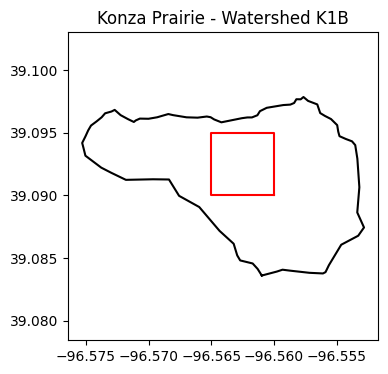

In [77]:
# Visualize that the arbitrary square is indeed within the watershed

plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')
plt.plot(b_lon, b_lat, '-r')
plt.axis('equal')
plt.show()


### Create grid

To create the grid cells within the watershed we have two options: 1) create a known number of cells that fit within the watershed, or 2) create as many grid cells as possible of a given size. Because of its irregular shape, we will create as many cells as possible of a given size. We will cover the entire bounding box of the water shed, and then eliminate those grdi cells that are not fully contained by the watershed boundaries.

Of course, the smaller the size of the grid cells, the more cells we can fit, and the closer they will follow the perimeter of the watershed.

An important observation is that grid cells will share their sides, they will be touching each other, but they will not be overlapping.

In [78]:
# Longitude vector
x_vec = np.linspace(watershed.bounds[0], watershed.bounds[2], 30) 

# Latitude vector
y_vec = np.linspace(watershed.bounds[1], watershed.bounds[3], 30)


An alternative that deserves some exploration is using the Numpy `meshgrid()` function and the Shapely `MultiPolygon` feature. In this particualr case I found that a straigth forward `for` loop and the use of an array of Shapely `Polygons` was simpler, at least for this particular problem.

### Generate tuples for each grid cell

In [79]:
grid = []
for i in range(len(x_vec)-1):
    for j in range(len(y_vec)-1):
        cell = box(x_vec[i], y_vec[j], x_vec[i+1], y_vec[j+1])
        grid.append(cell)
        

### Overlay grid on watershed map

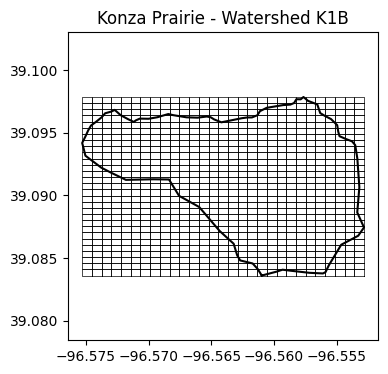

In [82]:
# Visualize grid
plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')

for cell in grid:
    cell_lon = list(cell.exterior.coords.xy[0])
    cell_lat = list(cell.exterior.coords.xy[1])
    plt.plot(cell_lon,cell_lat, '-k', linewidth=0.5)
    
plt.axis('equal')
plt.show()


### Exclude grid cells that are outside or overlap watershed

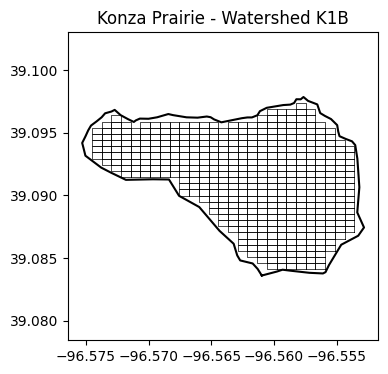

In [84]:
grid = []
for i in range(len(x_vec)-1):
    for j in range(len(y_vec)-1):
        cell = box(x_vec[i], y_vec[j], x_vec[i+1], y_vec[j+1])      
        if cell.within(watershed):
            grid.append(cell)


plt.figure(figsize=(4,4))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')


for cell in grid:
    cell_lon, cell_lat = list(cell.exterior.coords.xy)
    plt.plot(cell_lon, cell_lat, '-k', linewidth=0.5)
    
plt.axis('equal')
plt.show()


### Select random numer of cell within watershed

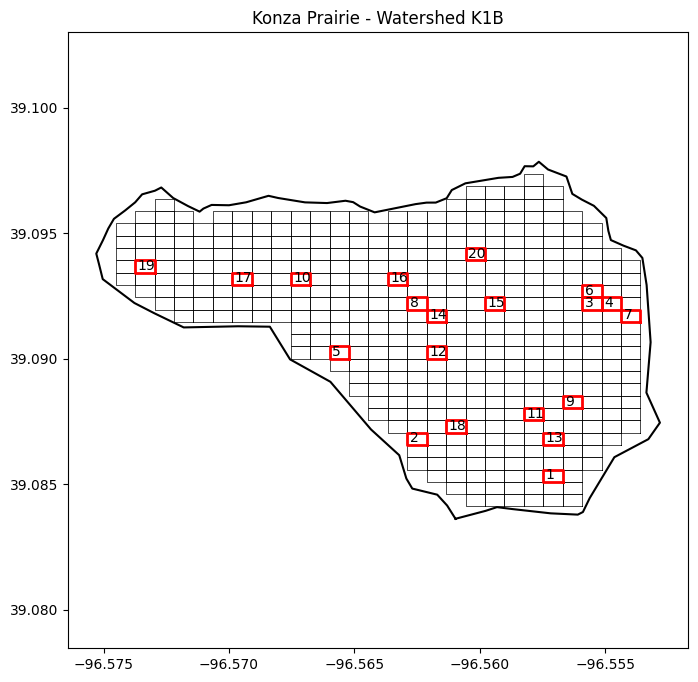

In [87]:
# For reproducibility
np.random.seed(99)

# Select random cells from the set within the watershed
sampling_cells = np.random.choice(grid, size=20, replace=False)

plt.figure(figsize=(8,8))
plt.title('Konza Prairie - Watershed K1B')
plt.plot(lon_watershed,lat_watershed, '-k')

for cell in grid:
    cell_lon, cell_lat = list(cell.exterior.coords.xy)
    plt.plot(cell_lon,cell_lat, '-k', linewidth=0.5)
    
for count,cell in enumerate(sampling_cells):
    cell_lon, cell_lat = list(cell.exterior.coords.xy)
    plt.plot(cell_lon,cell_lat, '-r',linewidth=2)
    
    # Add count + 1 to start numbering from one. Add a little offset to improve visualization on map.
    plt.annotate(str(count+1), xy=(cell_lon[3]+0.0001, cell_lat[3]+0.0001))
    
plt.axis('equal')
plt.show()


### Print centroid for each sampling cell

Thinking ahead on field work, it would be nice to have a the coordiantes for each cell. In this case we will print the Lower-Left corner of each cell. An alternative is to compute the cell centroid. You can easily do this using numpy. For instance:

```python

x_centroid = np.mean(cell_lon)
y_centroid = np.mean(cell_lat)

```

In [88]:
print("Coordinates for the lower-left corner of the each cell")
for count,cell in enumerate(sampling_cells):
    cell_lon, cell_lat = list(cell.exterior.coords.xy)
    print("Cell",count+1,"Lat:", cell_lat[3],"Lon:",cell_lon[3])

Coordinates for the lower-left corner of the each cell
Cell 1 Lat: 39.08509065793103 Lon: -96.55747036034482
Cell 2 Lat: 39.08656284586207 Lon: -96.5628934824138
Cell 3 Lat: 39.09196086827586 Lon: -96.55592089689655
Cell 4 Lat: 39.09196086827586 Lon: -96.55514616517242
Cell 5 Lat: 39.08999795103448 Lon: -96.56599240931035
Cell 6 Lat: 39.092451597586205 Lon: -96.55592089689655
Cell 7 Lat: 39.09147013896551 Lon: -96.55437143344827
Cell 8 Lat: 39.09196086827586 Lon: -96.5628934824138
Cell 9 Lat: 39.0880350337931 Lon: -96.55669562862069
Cell 10 Lat: 39.09294232689655 Lon: -96.56754187275862
Cell 11 Lat: 39.087544304482755 Lon: -96.55824509206896
Cell 12 Lat: 39.08999795103448 Lon: -96.56211875068965
Cell 13 Lat: 39.08656284586207 Lon: -96.55747036034482
Cell 14 Lat: 39.09147013896551 Lon: -96.56211875068965
Cell 15 Lat: 39.09196086827586 Lon: -96.55979455551724
Cell 16 Lat: 39.09294232689655 Lon: -96.56366821413793
Cell 17 Lat: 39.09294232689655 Lon: -96.56986606793104
Cell 18 Lat: 39.0870